In [216]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM, MORCGP, MORCGP_shared_noise, MOGPRegressor_NC_bounded_noise, MORCGP_bounded_noise, MOGPRegressor_bounded_noises, MORCGP_bounded_noises
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler
np.set_printoptions(precision=3, suppress=True)

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 18,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 5,    
    'lines.markersize': 8   
})

In [2]:
dfs = pd.read_excel(r'FNCL 28-8 11-09.xlsx', sheet_name=["FNCL 5 9 25", "FNCL 5.5 9 25", "FNCL 6 9 25"])
# df_fncl5, df_fncl5_5, df_fncl6 =
df_fncl5 = dfs["FNCL 5 9 25"]
df_fncl5_5 = dfs["FNCL 5.5 9 25"]
df_fncl6 = dfs["FNCL 6 9 25"]
df_fncl5

,Date,Last Price
0,2025-09-11 21:56:36,99-26
1,2025-09-11 21:56:36,99-26
2,2025-09-11 21:56:36,99-26
3,2025-09-11 21:56:36,99-26
4,2025-09-11 20:51:44,99-27+
...,...,...
1875,2025-08-28 13:12:02,98-20
1876,2025-08-28 13:02:02,98-19+
1877,2025-08-28 13:02:02,98-19
1878,2025-08-28 13:02:02,98-19+


In [193]:
def preprocess_data(dfs, securities, target_dates):
    df_fncl5 = dfs["FNCL 5 9 25"]
    df_fncl5_5 = dfs["FNCL 5.5 9 25"]
    df_fncl6 = dfs["FNCL 6 9 25"]

    # Only consider last price for same timestamp
    def process_last_price(df):
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(by=['Date'])
        result = df.groupby('Date', as_index=False).last()
        return result
    fncl5_last_price = process_last_price(df_fncl5)
    fncl5_5_last_price = process_last_price(df_fncl5_5)
    fncl6_last_price = process_last_price(df_fncl6)

    # Process bloomberg format to numeric
    def parse_bloomberg_price(price) -> float:
        if pd.isna(price):
            return None
        price_str = str(price)
        if "-" not in price_str:
            return float(price_str)
        whole, frac = price_str.split("-")
        whole = int(whole)
        if frac.endswith("+"):
            frac_val = int(frac[:-1]) + 0.5
        else:
            frac_val = int(frac)
        return whole + frac_val / 32.0
    fncl5_last_price["Last Price"] = fncl5_last_price["Last Price"].apply(parse_bloomberg_price)
    fncl5_5_last_price["Last Price"] = fncl5_5_last_price["Last Price"].apply(parse_bloomberg_price)
    fncl6_last_price["Last Price"] = fncl6_last_price["Last Price"].apply(parse_bloomberg_price)

    # Either two or three securities
    if securities == 2:
        def merge_two_prices(df1, df2, col_names=('fncl5', 'fncl5_5')):
            df1_renamed = df1[['Date', 'Last Price']].rename(columns={'Last Price': col_names[0]})
            df2_renamed = df2[['Date', 'Last Price']].rename(columns={'Last Price': col_names[1]})
            merged_df = df1_renamed.merge(df2_renamed, on='Date', how='outer')
            merged_df = merged_df.sort_values('Date').reset_index(drop=True)
            return merged_df
        merged_df = merge_two_prices(fncl5_last_price, fncl5_5_last_price)
    else:
        def merge_price_data(df1, df2, df3, col_names=('fncl5', 'fncl5_5', 'fncl6')):           
            df1_renamed = df1[['Date', 'Last Price']].rename(columns={'Last Price': col_names[0]})
            df2_renamed = df2[['Date', 'Last Price']].rename(columns={'Last Price': col_names[1]})
            df3_renamed = df3[['Date', 'Last Price']].rename(columns={'Last Price': col_names[2]})
            merged_df = df1_renamed.merge(df2_renamed, on='Date', how='outer') \
                                    .merge(df3_renamed, on='Date', how='outer')
            merged_df = merged_df.sort_values('Date').reset_index(drop=True)
            return merged_df
        merged_df = merge_price_data(fncl5_last_price, fncl5_5_last_price, fncl6_last_price)

    # Filter the dataframe for those dates
    df_selected_dates = merged_df[merged_df['Date'].dt.date.isin(target_dates)]

    def convert_date_to_minutes(df, date_col='Date'):
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col])
        df[date_col] = (df[date_col] - df[date_col].iloc[0]).dt.total_seconds() / 60.0
        return df
    df = convert_date_to_minutes(df_selected_dates)

    # X as the Date column
    X = df['Date'].to_numpy().reshape(-1,1)

    if securities == 2:
        Y = df[['fncl5', 'fncl5_5']].to_numpy()
    else:
        Y = df[['fncl5', 'fncl5_5', 'fncl6']].to_numpy()
    return X, Y

target_dates = pd.to_datetime(['2025-09-08', '2025-09-09', '2025-09-10']).date
# target_dates = pd.to_datetime(['2025-09-08', '2025-09-09', '2025-09-10']).date
x, Y = preprocess_data(dfs=dfs, securities=2, target_dates=target_dates)

In [194]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_std = scaler_X.fit_transform(x)
Y_std = scaler_Y.fit_transform(Y)

print("Means:", scaler_Y.mean_)
print("Standard deviations:", scaler_Y.scale_)

print(scaler_X.mean_)
print(scaler_X.scale_)

Means: [ 99.655 101.217]
Standard deviations: [0.089 0.06 ]
[1743.76]
[1188.412]


In [195]:
np.set_printoptions(precision=3, suppress=True)
print(X_std)

[[-1.467]
 [-1.459]
 [-1.446]
 [-1.438]
 [-1.43 ]
 [-1.416]
 [-1.409]
 [-1.4  ]
 [-1.388]
 [-1.379]
 [-1.371]
 [-1.362]
 [-1.35 ]
 [-1.341]
 [-1.333]
 [-1.32 ]
 [-1.312]
 [-1.303]
 [-1.291]
 [-1.282]
 [-1.274]
 [-1.265]
 [-1.253]
 [-1.244]
 [-1.236]
 [-1.223]
 [-1.215]
 [-1.207]
 [-1.194]
 [-1.186]
 [-1.177]
 [-1.169]
 [-1.156]
 [-1.148]
 [-1.139]
 [-1.127]
 [-1.118]
 [-1.11 ]
 [-1.097]
 [-1.089]
 [-1.08 ]
 [-1.072]
 [-1.059]
 [-1.051]
 [-1.042]
 [-1.03 ]
 [-1.021]
 [-1.013]
 [-0.255]
 [-0.247]
 [-0.235]
 [-0.226]
 [-0.218]
 [-0.205]
 [-0.197]
 [-0.188]
 [-0.176]
 [-0.167]
 [-0.159]
 [-0.15 ]
 [-0.138]
 [-0.129]
 [-0.121]
 [-0.109]
 [-0.1  ]
 [-0.092]
 [-0.079]
 [-0.07 ]
 [-0.062]
 [-0.053]
 [-0.049]
 [-0.037]
 [-0.033]
 [-0.024]
 [-0.012]
 [-0.003]
 [ 0.005]
 [ 0.018]
 [ 0.026]
 [ 0.035]
 [ 0.039]
 [ 0.043]
 [ 0.056]
 [ 0.064]
 [ 0.073]
 [ 0.085]
 [ 0.093]
 [ 0.102]
 [ 0.114]
 [ 0.123]
 [ 0.131]
 [ 0.14 ]
 [ 0.152]
 [ 0.161]
 [ 0.169]
 [ 0.182]
 [ 0.19 ]
 [ 0.199]
 [ 0.956]
 [ 0.965]


In [133]:
N, D = Y_std.shape

epsilon = 3/N
epsilons = np.array([epsilon]*D)
bound = 0.02
Y_train_clean = Y_std[~np.isnan(Y_std).any(axis=1)]
mcd = MinCovDet(support_fraction=1-epsilon*D).fit(Y_train_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)

# MOGP bounded noise
mogp = MOGPRegressor_NC_bounded_noise(mean=0, length_scale=0.05, noise=bound, A=robust_init_A)
mogp.fit(X_std, Y_std)
mogp.optimize_hyperparameters(bound=bound)
mu_mogp, var_mogp = mogp.predict(X_std)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# MORCGP bounded noise
morcgp = MORCGP_bounded_noise(mean=0, length_scale=0.05, noise_var=bound, A=robust_init_A)
morcgp.fit(X_std, Y_std, epsilons)
morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True, bound=bound)
mu_morcgp, var_morcgp = morcgp.predict(X_std)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

In [196]:
x_test = np.concatenate([
    np.linspace(-1.47, -0.99, 1000),
    np.linspace(-0.25, 0.23, 1000),
    np.linspace(0.97, 1.45, 1000)
])

In [271]:
N, D = Y_std.shape

epsilon = 5/N
epsilons = np.array([epsilon]*D)
bounds = ((1/128) / scaler_Y.scale_)**2
print(bounds)
Y_train_clean = Y_std[~np.isnan(Y_std).any(axis=1)]
mcd = MinCovDet(support_fraction=1-epsilon*D).fit(Y_train_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)

# bounds = np.array([1/32]*D)

X_std_test = np.concatenate([
    np.linspace(-1.47, -0.99, 1000),
    np.linspace(-0.25, 0.23, 1000),
    np.linspace(0.97, 1.45, 1000)
]).reshape(-1, 1)

# MOGP bounded noise
mogp = MOGPRegressor_bounded_noises(mean=0, length_scale=0.01, noise=bounds, A=robust_init_A)
mogp.fit(X_std, Y_std)
mogp.optimize_hyperparameters(bounds=bounds)
mu_mogp, var_mogp = mogp.predict(X_std_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# MORCGP bounded noise
morcgp = MORCGP_bounded_noises(mean=0, length_scale=0.01, noise_var=bounds, A=robust_init_A)
morcgp.fit(X_std, Y_std, epsilons)
morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True, bounds=bounds)
mu_morcgp, var_morcgp = morcgp.predict(X_std_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

[0.008 0.017]


In [272]:
true_mu_mogp = scaler_Y.inverse_transform(mu_mogp)
true_mu_morcgp = scaler_Y.inverse_transform(mu_morcgp)
x_test = scaler_X.inverse_transform(X_std_test)

In [269]:
x_test.shape

(3000, 1)

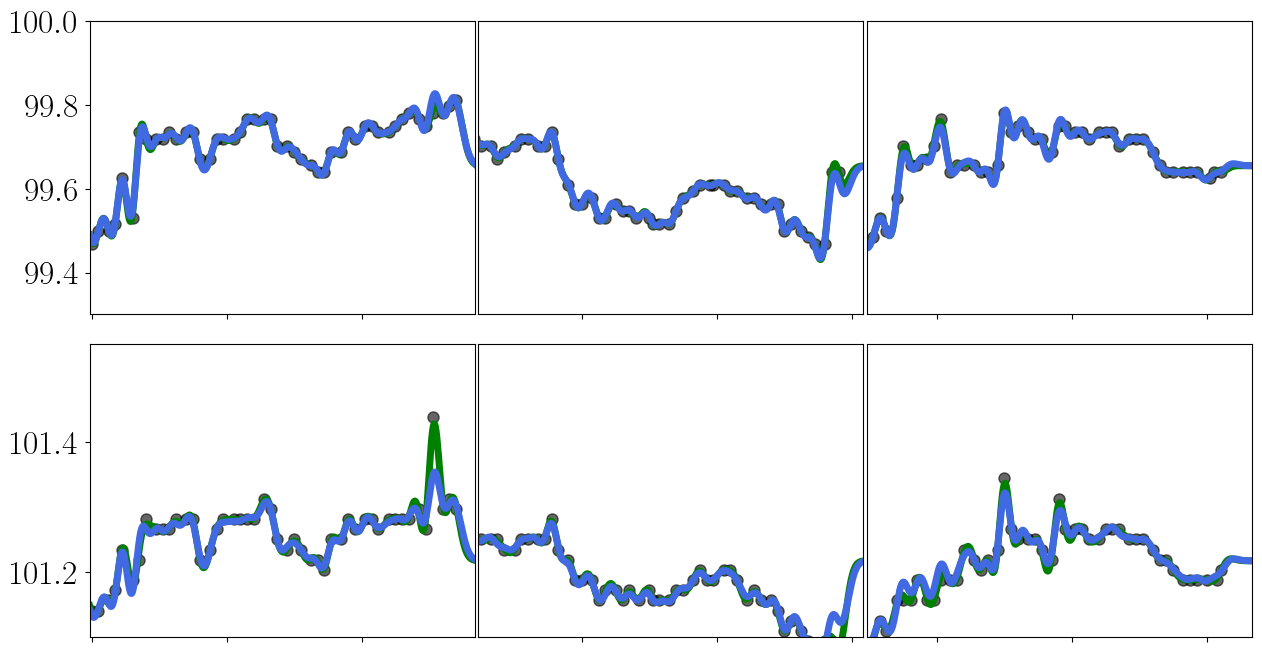

In [273]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Flatten all masks
mask1 = (x_test < 1000).flatten()
mask2 = ((x_test >= 1000) & (x_test < 2500)).flatten()
mask3 = (x_test >= 2500).flatten()

mask1_x = (x < 1000).flatten()
mask2_x = ((x >= 1000) & (x < 2500)).flatten()
mask3_x = (x >= 2500).flatten()

# Define masks for looping
masks = [mask1, mask2, mask3]
masks_x = [mask1_x, mask2_x, mask3_x]

# Define custom tick labels and their numeric values
tick_labels = ['8', '10', '12', '14', '16']
tick_positions_fraction = np.linspace(0, 16/17, len(tick_labels))  # relative positions along x-axis

# Define y-limits for each row (outputs)
y_limits = [(99.3, 100), (101.1, 101.55), (102.3, 102.7)]  # example values for row 0, 1, 2

for i in range(2):  # Outputs (rows)
    for j in range(3):  # Segments (columns)
        axes[i, j].plot(x[masks_x[j]], Y[masks_x[j], i], 'o', color='black', alpha=0.6)
        axes[i, j].plot(x_test[masks[j]], true_mu_mogp[masks[j], i], '-', color='Green')
        axes[i, j].plot(x_test[masks[j]], true_mu_morcgp[masks[j], i], '-', color='RoyalBlue')

        # Set x-axis limits
        x_min = x_test[masks[j]].min()
        x_max = x_test[masks[j]].max()
        axes[i, j].set_xlim(x_min, x_max)

        # Set y-axis limits for this row
        axes[i, j].set_ylim(y_limits[i])

        # Hide y-axis labels and ticks for 2nd and 3rd column
        if j != 0:
            axes[i, j].set_ylabel('')
            axes[i, j].tick_params(labelleft=False, left=False)

        # Handle bottom row x-axis
        if i != 2:
            axes[i, j].set_xlabel('')
            axes[i, j].tick_params(labelbottom=False)
        else:
            tick_positions = x_min + tick_positions_fraction * (x_max - x_min)
            axes[i, j].set_xticks(tick_positions)
            axes[i, j].set_xticklabels(tick_labels)

fig.subplots_adjust(wspace=0.01, hspace=0.1)  # adjust value as needed
# plt.tight_layout()  # optional, can still help with vertical spacing
plt.show()


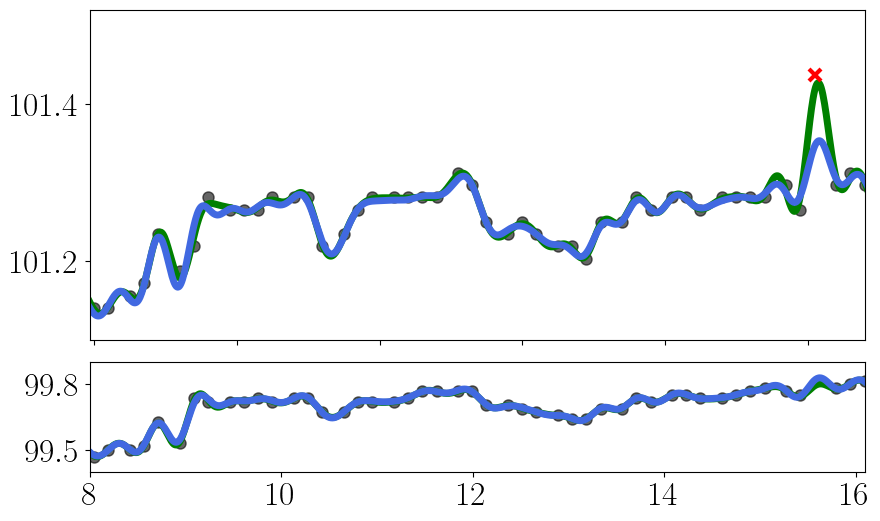

In [274]:
import matplotlib.pyplot as plt
import numpy as np

# Make top plot twice as large as bottom plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})

# Flatten all masks
mask1 = (x_test < 1000).flatten()
mask2 = ((x_test >= 1000) & (x_test < 2500)).flatten()
mask3 = (x_test >= 2500).flatten()

mask1_x = (x < 1000).flatten()
mask2_x = ((x >= 1000) & (x < 2500)).flatten()
mask3_x = (x >= 2500).flatten()

# Define masks for looping
masks = [mask1, mask2, mask3]
masks_x = [mask1_x, mask2_x, mask3_x]

# Define custom tick labels and their numeric values
tick_labels = ['8', '10', '12', '14', '16']
tick_positions_fraction = np.linspace(0, 16/17, len(tick_labels))  # relative positions along x-axis

# Define y-limits for each row (outputs)
y_limits = [(99.4, 99.9), (101.1, 101.52), (102.3, 102.7)]  # example values for row 0, 1, 2

# Index of the special point
special_idx = 44

for i in range(2):  # Rows
    for j in range(1):  # Only one column now
        axes_to_use = axes[1 - i]  # 0->1, 1->0

        # Mask out the special index
        mask_to_plot = masks_x[j].copy()
        mask_to_plot[special_idx] = False  # Exclude the special point

        axes_to_use.plot(x[mask_to_plot], Y[mask_to_plot, i], 'o', color='black', alpha=0.6)
        axes_to_use.plot(x_test[masks[j]], true_mu_mogp[masks[j], i], '-', color='Green')
        axes_to_use.plot(x_test[masks[j]], true_mu_morcgp[masks[j], i], '-', color='RoyalBlue')

        # Set x-axis limits
        x_min = x_test[masks[j]].min()
        x_max = x_test[masks[j]].max()
        axes_to_use.set_xlim(x_min, 540)

        # Set y-axis limits for this row
        axes_to_use.set_ylim(y_limits[i])

        # Show x-axis labels only for bottom row
        if axes_to_use != axes[-1]:  # If not bottom row, hide labels
            axes_to_use.set_xlabel('')
            axes_to_use.tick_params(labelbottom=False)
        else:  # Bottom row
            tick_positions = x_min + tick_positions_fraction * (x_max - x_min)
            axes_to_use.set_xticks(tick_positions)
            axes_to_use.set_xticklabels(tick_labels)

# Plot only the special point as a red cross
axes[0].plot(x[special_idx, 0], Y[special_idx, 1], 'x', color='red', markeredgewidth=3)

axes[0].set_yticks([101.2, 101.4])
axes[1].set_yticks([99.5, 99.8])

fig.subplots_adjust(hspace=0.1)
plt.show()

fig.savefig("./bloomberg.pdf", format='pdf', bbox_inches='tight')

In [233]:
print(Y[44, 1])

101.4375


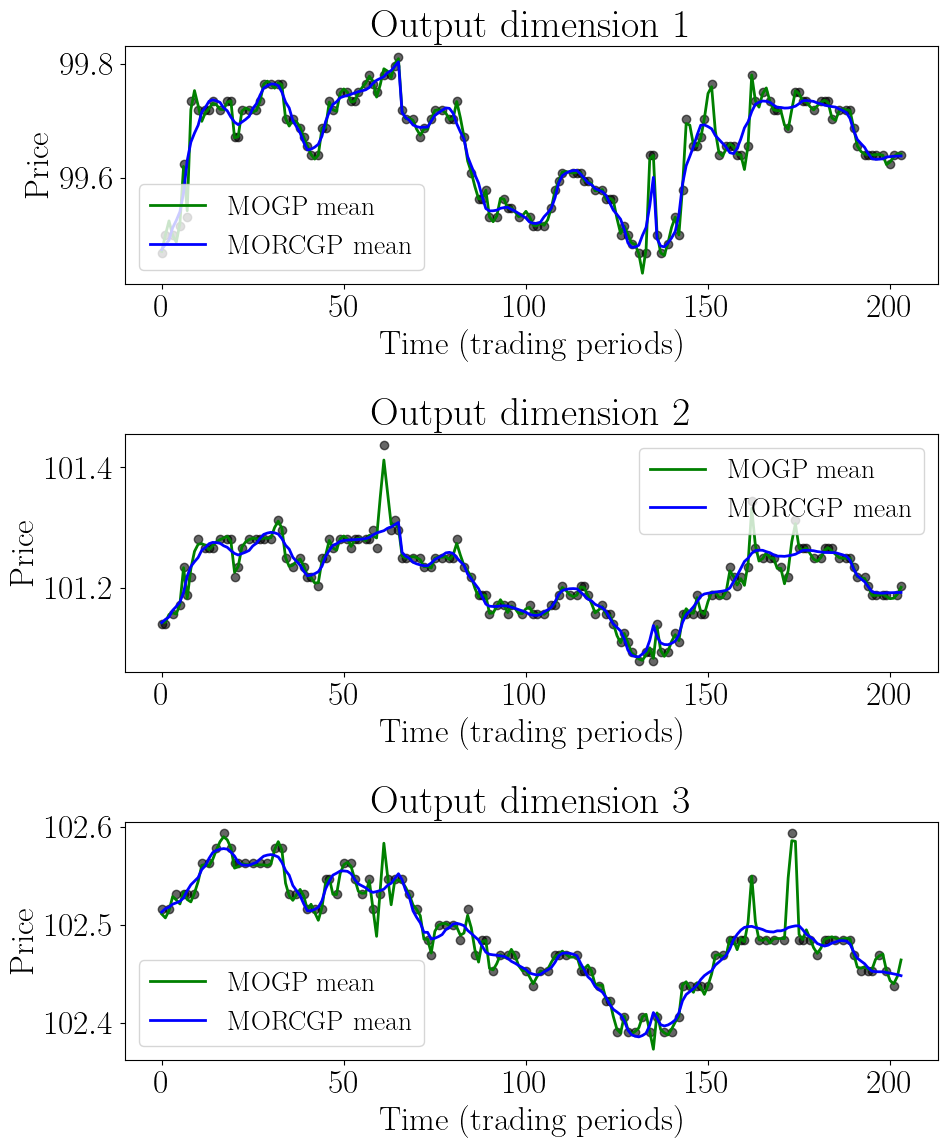

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example: x is datetime, Y is prices
# Let's assume x is a pandas DatetimeIndex or array of datetimes
# Keep only trading times
trading_times = x  # x already has only the trading timestamps

# Convert x to an ordinal trading index
x_index = np.arange(len(trading_times))

fig, axes = plt.subplots(3, 1, figsize=(10, 12))  # 3 rows, 1 column

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(x_index, Y[:, i], 'o', color='black', markersize=6, alpha=0.6)
    
    # Plot MOGP predictions
    ax.plot(x_index, true_mu_mogp[:, i], '-', color='green', linewidth=2, label='MOGP mean')
    
    # Plot MORCGP predictions
    ax.plot(x_index, true_mu_morcgp[:, i], '-', color='blue', linewidth=2, label='MORCGP mean')
    
    ax.set_title(f'Output dimension {i+1}')
    ax.set_xlabel('Time (trading periods)')
    ax.set_ylabel('Price')
    ax.legend()

plt.tight_layout()
plt.show()
